# CNN Autoencoder Image Inpainter

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
%matplotlib inline

In [2]:
import os
import sys
import keras
import tarfile
import urllib.request as urllib
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.engine.training import Model
from keras import backend as K, regularizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
import scipy.io as sio
from keras.utils import to_categorical
import keras.models

**Downloading the model through `wget`**

In [3]:
%%shell
rm -rf *
# getting the keras_model direc zipped file (>100 MB through wget)
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW" -O keras_model.zip && rm -rf /tmp/cookies.txt

# unzip under /content/ directory
unzip -q keras_model.zip

--2021-04-09 16:59:35--  https://docs.google.com/uc?export=download&confirm=Z3Mi&id=1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW
Resolving docs.google.com (docs.google.com)... 173.194.76.101, 173.194.76.138, 173.194.76.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.76.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ac-docs.googleusercontent.com/docs/securesc/4psb9ajdivdjhat28d4upm4osj9mv9ec/g6e7nfi5j8cd6im1e8vj041tpglukbe8/1617987525000/13881832785567679767/09350826646865322032Z/1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW?e=download [following]
--2021-04-09 16:59:35--  https://doc-08-ac-docs.googleusercontent.com/docs/securesc/4psb9ajdivdjhat28d4upm4osj9mv9ec/g6e7nfi5j8cd6im1e8vj041tpglukbe8/1617987525000/13881832785567679767/09350826646865322032Z/1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW?e=download
Resolving doc-08-ac-docs.googleusercontent.com (doc-08-ac-docs.googleusercontent.com)... 74.125.206.132, 2a00:1450:400c:c04::84
Connecting

## Load Data

In [4]:
# default batch size
batch_size = 10

tf = transforms.Compose([transforms.ToTensor()])

# split={'train', 'test', 'extra'} <- choose one size to download
# dataset = datasets.SVHN('data', split='extra', download=True, transform=tf)
dataset = datasets.SVHN('data', split='extra', download=True, transform=tf)

In [5]:
# split the extra dataset in quarter
indices = np.random.randint(low=0, high=len(dataset) -1, size=(len(dataset)//2))
dataset_sub = torch.utils.data.Subset(dataset, indices)

N = len(dataset_sub)
val_size, test_size = int(N *0.1), int(N *0.1) #10-10-80 Split
train_size = N - val_size - test_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset_sub, [train_size, val_size, test_size])
print(f'training size: {len(train_set)}')
print(f'val size: {len(val_set)}')
print(f'test size: {len(test_set)}')

training size: 106226
val size: 13278
test size: 13278


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last = True)

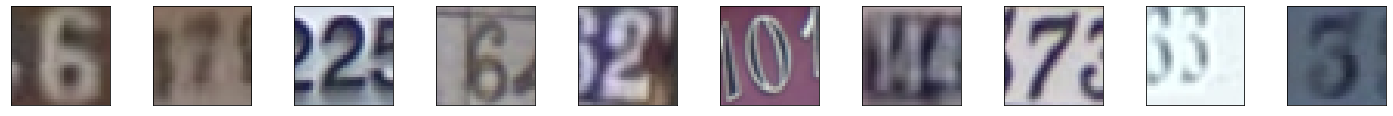

In [7]:
# Obtain batch of imgs from loader
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# Plot images as example
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
     plt.imshow(np.transpose(images[idx], (1, 2, 0)))

## Model Architecture

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class AutoencoderLarge(nn.Module):
    '''
    based on stanford model structure
    '''
    def __init__(self):
        super(AutoencoderLarge, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, padding=2), # 32*32*32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 16*16*64
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 8*8*128
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), # 4*4*256
            nn.ReLU(),
            nn.Conv2d(256, 1024, 4, stride=1, padding=0), # bottle neck: 1*1*1024
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, 4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=1, padding=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class AutoencoderNew(nn.Module):
    '''
    chosen model
    '''
    def __init__(self):
        super(AutoencoderNew, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
		    nn.Conv2d(24, 48, 4, stride=2, padding=1),
        )
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
		    nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training Helpers

In [9]:
# helper function to un-normalize and display an image
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [10]:
def get_model_name(name, batch_size, learning_rate, epoch, acc):
    """ Generate a name for the model consisting of all the hyperparameter values
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}_acc{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch, acc)
    return path

**Random Masking Helper**

In [11]:
def mask_images (images, blocking=-1):
    '''
    @blocking = -1 set random blocking size
    we constrain the random int range to ensure the blocking is on the number
    '''
    ### preprocessing step to add masking to image batch###
    masked_imgs = images.detach().clone() # deep copy from images
    # add some randomness to the blocking size
    if blocking == -1:
        blocking = np.random.randint(low=8, high=12)
    offset = blocking // 2 # offset fromt the center

    midpoint_x = np.random.randint(offset+8, 28-offset)
    midpoint_y = np.random.randint(offset+8, 28-offset)
    masked_imgs[:, :, midpoint_x-offset: midpoint_x+offset, midpoint_y-offset: midpoint_y+offset] = 0 # block by setting all channels to 0
    return masked_imgs

**KERAS Get Accuracy Section**

In [12]:
from keras.preprocessing.image import ImageDataGenerator
# applying transformation to image
train_gen = ImageDataGenerator(
   rotation_range=15,
   zoom_range = 0.10,
   width_shift_range=0.3,
   height_shift_range=0.3,
   brightness_range=[0.2,1.0]
)


In [13]:
loaded_model = keras.models.load_model('/content/keras_model')

In [14]:
def get_accuracy_keras (model, data_loader, batch_size, blocking=-1, verbose=False):
    loss, accuracy = 0.0, 0.0
    samples = 0
    for i, (images, labels) in enumerate(data_loader):
        if i > 10:
            break
        ### preprocessing step to add masking to image batch###
        masked_imgs = mask_images(images, blocking)
    
        ### to enable GPU usage ###
        if torch.cuda.is_available():
            images = images.cuda()
            masked_imgs = masked_imgs.cuda()
    
        outputs = model(masked_imgs)
    
        #KERAS part
        images = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        one_hot_labels = to_categorical(labels, 10)
        images = np.transpose(images, (0, 2, 3, 1))
        # Converting the arrays to Float type
        images = images.astype('float32')
        # Normalizing
        images = images / 255.0
        keras_batch = train_gen.flow(images, one_hot_labels, batch_size=batch_size)
        new_loss, new_accuracy = loaded_model.evaluate(keras_batch, verbose=verbose)

        loss += new_loss
        accuracy += new_accuracy
        samples += 1

    return loss/samples, accuracy/samples


**Main Training Helpers**

In [15]:
import time
# for keep track of the best model weights
import copy
def evaluate(model, data_loader, criterion, blocking=-1):
    total_loss = 0.0
    total_sample = 0

    for i, data in enumerate(data_loader):
        if i >10:
            break
        images, _ = data

        ### preprocessing step to add masking to image batch###
        masked_imgs = mask_images(images, blocking)

        ### to enable GPU usage ###
        if torch.cuda.is_available():
            images = images.cuda()
            masked_imgs = masked_imgs.cuda()

        outputs = model(masked_imgs)
        loss = criterion(outputs, images)
        total_loss += loss.item()
        total_sample += len(data)
    loss = total_loss / total_sample
    return loss

def train(model, batch_size=64, num_epochs=5, learning_rate=0.001, wd=1e-5,
          small=False, blocking=-1, verbose=True):
    '''
    Main trainign function for CNN autoencoder.
    @wd: weight decay param for Adam optimizer
    @small: whether to use a small subset to train and verify for sanity check
    @blocking: size of blocking to apply at the center of the image (must <= 32)
    @verbose: whether to print out progress logs
    '''
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                               weight_decay=wd)

    # flag set whether to train on a small subset of the SVHN dataset
    if small:
        train_indices = np.random.randint(low=0, high=len(train_set), size=1000)
        val_indices = np.random.randint(low=0, high=len(val_set), size=200)
        test_indices = np.random.randint(low=0, high=len(test_set), size=200)
        train_set_small = torch.utils.data.Subset(train_set, train_indices)
        val_set_small = torch.utils.data.Subset(val_set, val_indices)
        test_set_small = torch.utils.data.Subset(test_set, test_indices)
        train_loader = torch.utils.data.DataLoader(train_set_small, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_set_small, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set_small, batch_size=batch_size, shuffle=True)
        sample_rate = 10
    else:
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
        sample_rate = 50

    ############### Trackers ################
    # train & validation loss trackers
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    # for visualizing the inpainting effectiveness (only log first 10 outputs)
    outputs_log = []
    # tracking the best model weights so far based on best accuaracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    iter = 0
    start_time = time.time()
    for epoch in range(1, num_epochs+1):
      
        for data in train_loader:
            images, _ = data
            optimizer.zero_grad()

            ### preprocessing step to add masking to image batch###
            masked_imgs = mask_images(images, blocking = blocking)

            # visualize some of the masked images
            if not iter:
                num_images = masked_imgs.detach().clone().numpy()
                plt.figure(figsize=(3,3))
                imshow(num_images[2])

            ### to enable GPU usage ###
            if torch.cuda.is_available():
                images = images.cuda()
                masked_imgs = masked_imgs.cuda()
  
            outputs = model(masked_imgs)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            # track the training & validation loss
            if (iter+1) % sample_rate == 0:
                # log progress to the trackers
                train_loss.append(loss.item())
                val_loss.append(evaluate(model, val_loader, criterion, blocking))
                train_acc.append(get_accuracy_keras(model, train_loader, batch_size, blocking, False)[1])
                val_acc.append(get_accuracy_keras(model, val_loader, batch_size, blocking, False)[1])
                if verbose:
                    print('iter {}: train_acc: {:.4f}, train_loss: {:.4f} | val_acc: {:.4f}, val_loss: {:.4f} | e_time: {:.2f}s'.format(
                            iter+1, train_acc[-1], train_loss[-1], val_acc[-1], val_loss[-1], time.time() - start_time
                        ))

                # deep copy the model to track the weights yields the best classification accuracy on inpainted images
                if train_acc[-1] > best_acc:
                    best_acc = train_acc[-1]
                    best_model_wts = copy.deepcopy(model.state_dict())

            # log the first 10 batch of images along with reconstructed imgs for visualization
            if iter % 150 == 0 and iter <= 750:
                outputs_log.append((masked_imgs.cpu(), outputs.cpu()))

            iter += 1


    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # load the best model weights
    model.load_state_dict(best_model_wts)

    # evaluate on the testset
    test_loss = evaluate(model, test_loader, criterion)
    _, test_acc = get_accuracy_keras(model, test_loader, batch_size, blocking, False)
    print("Final test acc: {:.4f} | test loss: {:.4f}".format(
        test_acc, test_loss
    ))

    # Creates two subplots and unpacks the output array immediately
    n = len(train_loss) # number of samples
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.set_title("Multi-classifier Accuracy over Inpainted Images")
    ax1.plot(range(1,n+1), train_acc, label="Train")
    ax1.plot(range(1,n+1), val_acc, label="Validation")
    ax1.set_xlabel(f"Samplings (per 50 iters)")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='best')
    ax2.set_title("Train vs Validation Loss")
    ax2.plot(range(1,n+1), train_loss, label="Train")
    ax2.plot(range(1,n+1), val_loss, label="Validation")
    ax2.set_xlabel(f"Samplings (per 50 iters)")
    ax2.set_ylabel("Loss")
    ax2.legend(loc='best')
    plt.show()

    return model, outputs_log


## Fine Tuning

### Learning Rate

In [ ]:
import math
def find_lr(model, init_value=1e-8, final_value=10., beta=0.98, batch_size=10):
    '''
    Training funciton used for fine tuning learning rate
    Used momentum method to "smooth" out the loss for each mini-batch
    avg loss = beta * old avg loss + (1 - beta) * loss
    '''
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=init_value)

    # Use small training set
    train_indices = np.random.randint(low=0, high=len(train_set), size=5000)
    train_set_small = torch.utils.data.Subset(train_set, train_indices)
    train_loader = torch.utils.data.DataLoader(train_set_small, batch_size=batch_size, shuffle=True)

    num = len(train_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    # optimizer.param_groups[0]['lr'] = lr
    avg_loss, best_loss, batch_num = 0., 0., 0
    losses, log_lrs = [], []

    for data in train_loader:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        images, _ = data
        optimizer.zero_grad()

        ### preprocessing step to add masking to image batch###
        masked_imgs = images.detach().clone() # deep copy from images
        offset = 8 // 2 # offset from the center (16)
        masked_imgs[:, :, 16-offset: 16+offset, 16-offset: 16+offset] = 0 # block by setting all channels to 0

        outputs = model(masked_imgs)
        loss = criterion(outputs, images)

        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))

        loss.backward()
        optimizer.step()

        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

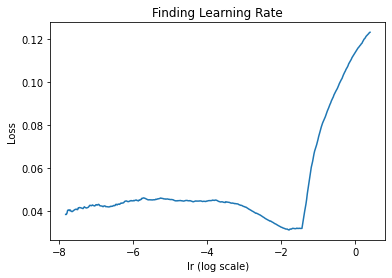

In [ ]:
temp_model = AutoencoderNew()
logs,losses = find_lr(temp_model, beta=0.99)
plt.title('Finding Learning Rate')
plt.ylabel('Loss')
plt.xlabel('lr (log scale)')
plt.plot(logs[10:-5],losses[10:-5])

Now we would like to choose the best learning rate before we start. Not the one corresponding to the minimum but pick one order of magnitude before. In this case we don't want to pick 1e-2 but 1e-3 (rule of thumb: one order of magnitude below the local min).

## Training Model

Training on GPU...
iter 50: train_acc: 0.1072, train_loss: 0.0231 | val_acc: 0.1037, val_loss: 0.0135 | e_time: 41.02s
iter 100: train_acc: 0.2131, train_loss: 0.0171 | val_acc: 0.2159, val_loss: 0.0081 | e_time: 49.63s
iter 150: train_acc: 0.3473, train_loss: 0.0118 | val_acc: 0.3885, val_loss: 0.0057 | e_time: 58.29s
iter 200: train_acc: 0.4588, train_loss: 0.0087 | val_acc: 0.4673, val_loss: 0.0048 | e_time: 67.02s
iter 250: train_acc: 0.6278, train_loss: 0.0084 | val_acc: 0.6385, val_loss: 0.0040 | e_time: 75.65s
iter 300: train_acc: 0.7230, train_loss: 0.0061 | val_acc: 0.7287, val_loss: 0.0030 | e_time: 84.31s
iter 350: train_acc: 0.7763, train_loss: 0.0046 | val_acc: 0.7869, val_loss: 0.0024 | e_time: 92.98s
iter 400: train_acc: 0.8139, train_loss: 0.0053 | val_acc: 0.7969, val_loss: 0.0022 | e_time: 101.86s
iter 450: train_acc: 0.8310, train_loss: 0.0041 | val_acc: 0.8324, val_loss: 0.0020 | e_time: 110.50s
iter 500: train_acc: 0.8665, train_loss: 0.0036 | val_acc: 0.8622, val_

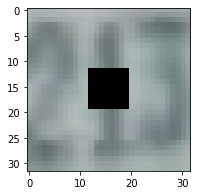

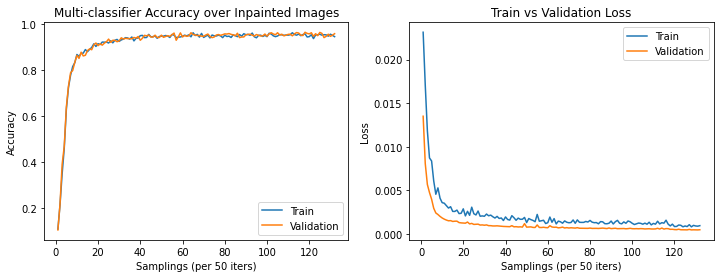

In [ ]:
inpainter_new = AutoencoderNew()
if torch.cuda.is_available():
    inpainter_new.cuda()
    print('Training on GPU...')
else:
    print('GPU is not available. Training on CPU...')
inpainter_new, outputs_log_new = train(inpainter_new, batch_size=128, num_epochs=4, learning_rate=0.001,
                                   wd=1e-5, small=False, verbose=True)


Training on GPU...
iter 50: train_acc: 0.1321, train_loss: 0.0247 | val_acc: 0.1001, val_loss: 0.0115 | e_time: 11.49s
iter 100: train_acc: 0.1619, train_loss: 0.0168 | val_acc: 0.1562, val_loss: 0.0081 | e_time: 20.58s
iter 150: train_acc: 0.2386, train_loss: 0.0136 | val_acc: 0.2713, val_loss: 0.0070 | e_time: 29.69s
iter 200: train_acc: 0.2536, train_loss: 0.0106 | val_acc: 0.3075, val_loss: 0.0060 | e_time: 38.81s
iter 250: train_acc: 0.3203, train_loss: 0.0102 | val_acc: 0.3068, val_loss: 0.0055 | e_time: 47.95s
iter 300: train_acc: 0.4027, train_loss: 0.0099 | val_acc: 0.4162, val_loss: 0.0048 | e_time: 57.10s
iter 350: train_acc: 0.4688, train_loss: 0.0080 | val_acc: 0.4680, val_loss: 0.0049 | e_time: 66.52s
iter 400: train_acc: 0.5178, train_loss: 0.0083 | val_acc: 0.4673, val_loss: 0.0043 | e_time: 75.76s
iter 450: train_acc: 0.5192, train_loss: 0.0091 | val_acc: 0.5241, val_loss: 0.0041 | e_time: 85.01s
iter 500: train_acc: 0.5540, train_loss: 0.0073 | val_acc: 0.5419, val_lo

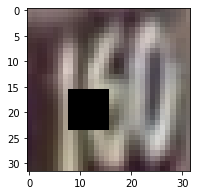

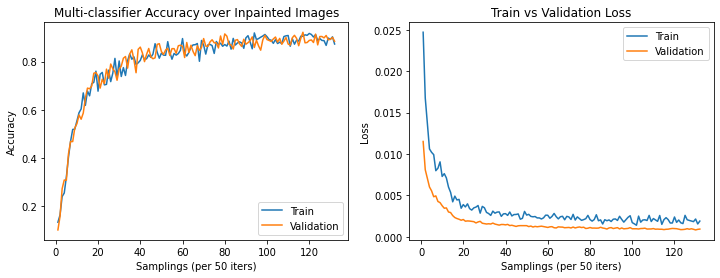

In [16]:
inpainter_new = AutoencoderNew()
if torch.cuda.is_available():
    inpainter_new.cuda()
    print('Training on GPU...')
else:
    print('GPU is not available. Training on CPU...')
inpainter_new, outputs_log_new = train(inpainter_new, batch_size=128, num_epochs=4, learning_rate=0.001,
                                   wd=1e-5, small=False, verbose=True)

In [19]:
path = get_model_name('samnet_med_randPosSize', batch_size=128, learning_rate=1e-3, epoch=8, acc=87)
torch.save(inpainter_new, path)

## Visualizing Training Progress

Below is the result of trainign progress when setting "small" flag to True (1000 training size).

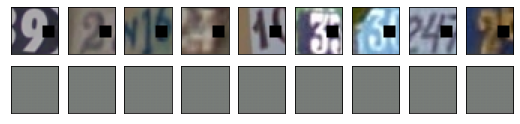

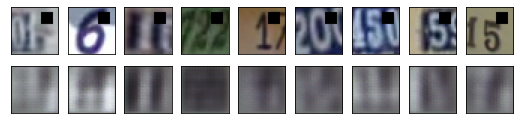

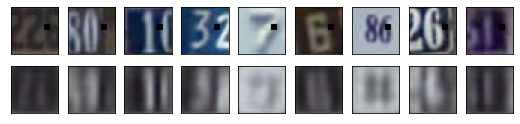

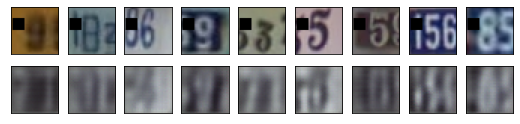

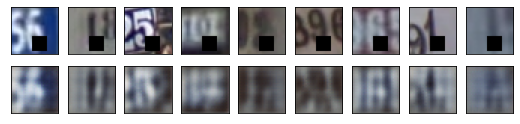

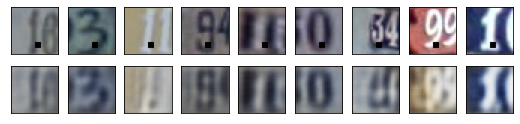

In [38]:
outputs_log = outputs_log_new
for k in range(0, len(outputs_log)):
    plt.figure(figsize=(9, 2))
    imgs = outputs_log[k][0].detach().numpy()
    recon = outputs_log[k][1].detach().numpy()
    for i, img in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1, xticks=[], yticks=[])
        imshow(img)
        
    for i, img in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1, xticks=[], yticks=[])
        imshow(img)

## Visualizing Result

In [ ]:
# load the model
# inpainter_new = torch.load('/content/model_samnet_extra_bs128_lr0.001_epoch4_acc95.45')
# inpainter_new.eval()

AutoencoderNew(
  (encoder): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [17]:
def visualize_model(model, data_loader):
    # obtain one batch of test images
    dataiter = iter(data_loader)
    images, labels = dataiter.next()

    ### preprocessing step to add masking to image batch###
    masked_imgs = images.detach().clone() # deep copy from images
    # add some randomness to the blocking size
    blocking = np.random.randint(low=8, high=12, size=len(images))
    offset = blocking // 2 # offset fromt he center (16)

    midpoint_x = np.random.randint(offset+8, 28-offset, size=len(images))
    midpoint_y = np.random.randint(offset+8, 28-offset, size=len(images))
    print(masked_imgs.shape)
    for i in range(len(images)):
        masked_imgs[i, :, midpoint_x[i]-offset[i]: midpoint_x[i]+offset[i], midpoint_y[i]-offset[i]: midpoint_y[i]+offset[i]] = 0 # block by setting all channels to 0
    
    # get sample outputs for display
    output = model(masked_imgs)
    # use detach when it's an output that requires_grad
    output = output.detach().numpy()

    # prep images for display
    images = images.numpy()

    # Plot input images
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(images[idx])

    # Plot masked images
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(masked_imgs[idx])
    
    # Plot result images
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(output[idx])

batch_size = 64
torch.manual_seed(0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

torch.Size([64, 3, 32, 32])


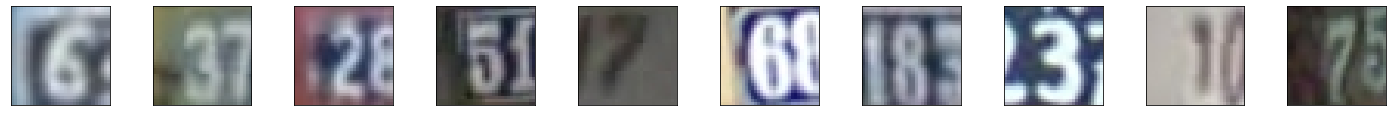

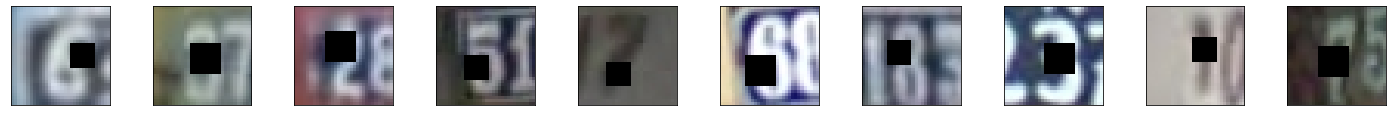

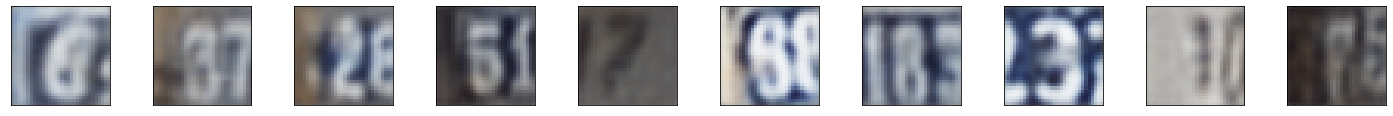

In [23]:
# New Model
visualize_model(inpainter_new.cpu(), test_loader)